# Invoice Field Detection — U-Net / Deep Learning

Este notebook implementa un pipeline completo de detección de campos en facturas/recibos.  
El dataset contiene:
- **`data/img/`** — imágenes de recibos (626 JPGs)
- **`data/box/`** — anotaciones de bounding boxes (CSV: `x1,y1,x2,y2,x3,y3,x4,y4,texto`)
- **`data/key/`** — etiquetas de campos clave (JSON: `company`, `date`, `address`, `total`)

**Objetivo:** Localizar y clasificar los campos clave (`company`, `date`, `address`, `total`) dentro de cada imagen de recibo mediante segmentación semántica con U-Net.

## 1. Importar Librerías

In [1]:
import os
import glob
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU disponible: []


In [2]:
# ─── Rutas del dataset ───────────────────────────────────────────────────────
BASE_DIR  = os.path.dirname(os.path.abspath("invoice_field_detection.ipynb"))
DATA_DIR  = os.path.join(BASE_DIR, "data")
IMG_DIR   = os.path.join(DATA_DIR, "img")
BOX_DIR   = os.path.join(DATA_DIR, "box")
KEY_DIR   = os.path.join(DATA_DIR, "key")

# ─── Hiperparámetros ──────────────────────────────────────────────────────────
IMG_H, IMG_W = 512, 512          # Tamaño de entrada al modelo
NUM_CLASSES  = 5                 # background, company, date, address, total
BATCH_SIZE   = 8
EPOCHS       = 30
SEED         = 42

# Mapa de campo → clase
FIELD_CLASSES = {"background": 0, "company": 1, "date": 2, "address": 3, "total": 4}
CLASS_COLORS  = {0: (0,0,0), 1: (255,0,0), 2: (0,255,0), 3: (0,0,255), 4: (255,255,0)}
CLASS_NAMES   = ["background", "company", "date", "address", "total"]

print("Rutas configuradas correctamente.")
print(f"  IMG_DIR : {IMG_DIR}")
print(f"  BOX_DIR : {BOX_DIR}")
print(f"  KEY_DIR : {KEY_DIR}")

Rutas configuradas correctamente.
  IMG_DIR : /content/data/img
  BOX_DIR : /content/data/box
  KEY_DIR : /content/data/key


## 2. Cargar y Explorar el Dataset

In [10]:
def load_sample(idx: str):
    """
    Carga imagen, bounding boxes y etiquetas clave para un índice dado.
    El CSV tiene columnas: x1,y1,x2,y2,x3,y3,x4,y4,text  (sin encabezado)
    El JSON contiene: company, date, address, total
    """
    img_path = os.path.join(IMG_DIR, f"{idx}.jpg")
    box_path = os.path.join(BOX_DIR, f"{idx}.csv")
    key_path = os.path.join(KEY_DIR, f"{idx}.json")

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Manual parsing to handle commas in the text field
    data = []
    with open(box_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.strip().split(",")
            # We expect at least 8 coordinates + 1 text (or empty text)
            if len(parts) >= 8:
                try:
                    # Extract coordinates (first 8 values)
                    coords = [int(p) for p in parts[:8]]
                    # The rest is the text (re-joined in case of commas)
                    text = ",".join(parts[8:])
                    data.append(coords + [text])
                except ValueError:
                    # Skip malformed lines (e.g. headers or non-integer coords)
                    continue

    boxes_df = pd.DataFrame(data, columns=["x1","y1","x2","y2","x3","y3","x4","y4","text"])

    with open(key_path) as f:
        keys = json.load(f)

    return img, boxes_df, keys


# ─── Listar todos los índices disponibles ────────────────────────────────────
all_indices = sorted([
    os.path.splitext(os.path.basename(p))[0]
    for p in glob.glob(os.path.join(IMG_DIR, "*.jpg"))
])

print(f"Total de muestras: {len(all_indices)}")
print(f"Primeros índices  : {all_indices[:5]}")
print(f"Últimos índices   : {all_indices[-5:]}")

# ─── Estadísticas básicas ─────────────────────────────────────────────────────
if all_indices:
    img_sample, boxes_sample, keys_sample = load_sample(all_indices[0])
    print(f"\nEjemplo índice {all_indices[0]}:")
    print(f"  Imagen shape : {img_sample.shape}")
    print(f"  Num bboxes   : {len(boxes_sample)}")
    print(f"  Campos clave : {list(keys_sample.keys())}")
    print(f"  Valores      : {keys_sample}")
else:
    print("No se encontraron imágenes en el directorio data/img.")

Total de muestras: 626
Primeros índices  : ['000', '001', '002', '003', '004']
Últimos índices   : ['621', '622', '623', '624', '625']

Ejemplo índice 000:
  Imagen shape : (1013, 463, 3)
  Num bboxes   : 44
  Campos clave : ['company', 'date', 'address', 'total']
  Valores      : {'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}


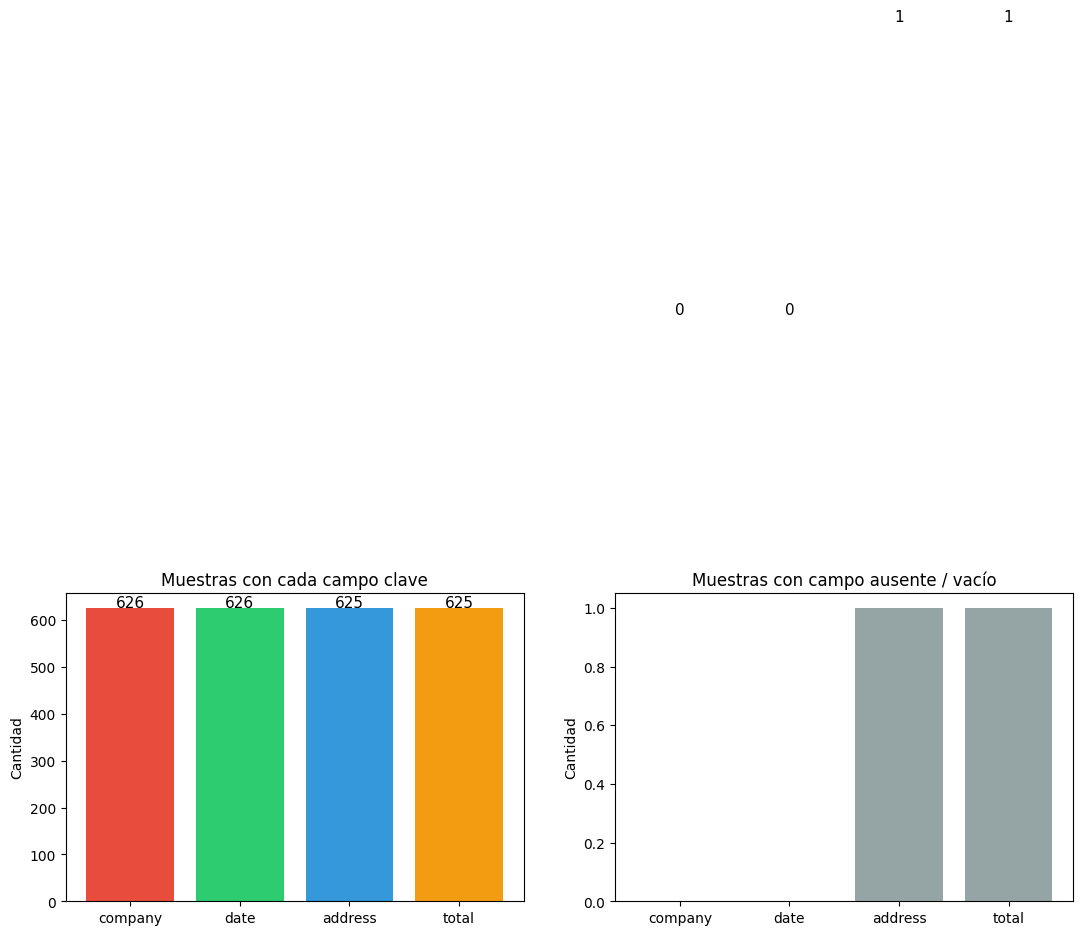

In [11]:
# ─── Distribución de campos clave en todo el dataset ─────────────────────────
field_counts = {f: 0 for f in FIELD_CLASSES if f != "background"}
missing       = {f: 0 for f in field_counts}

for idx in all_indices:
    key_path = os.path.join(KEY_DIR, f"{idx}.json")
    try:
        with open(key_path) as f:
            keys = json.load(f)
        for field in field_counts:
            if keys.get(field):
                field_counts[field] += 1
            else:
                missing[field] += 1
    except Exception:
        pass

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].bar(field_counts.keys(), field_counts.values(), color=["#E74C3C","#2ECC71","#3498DB","#F39C12"])
axes[0].set_title("Muestras con cada campo clave")
axes[0].set_ylabel("Cantidad")
for i, (k, v) in enumerate(field_counts.items()):
    axes[0].text(i, v + 2, str(v), ha="center", fontsize=11)

axes[1].bar(missing.keys(), missing.values(), color="#95A5A6")
axes[1].set_title("Muestras con campo ausente / vacío")
axes[1].set_ylabel("Cantidad")
for i, (k, v) in enumerate(missing.items()):
    axes[1].text(i, v + 2, str(v), ha="center", fontsize=11)

plt.tight_layout()
plt.show()

## 3. Visualizar Imágenes con Bounding Boxes

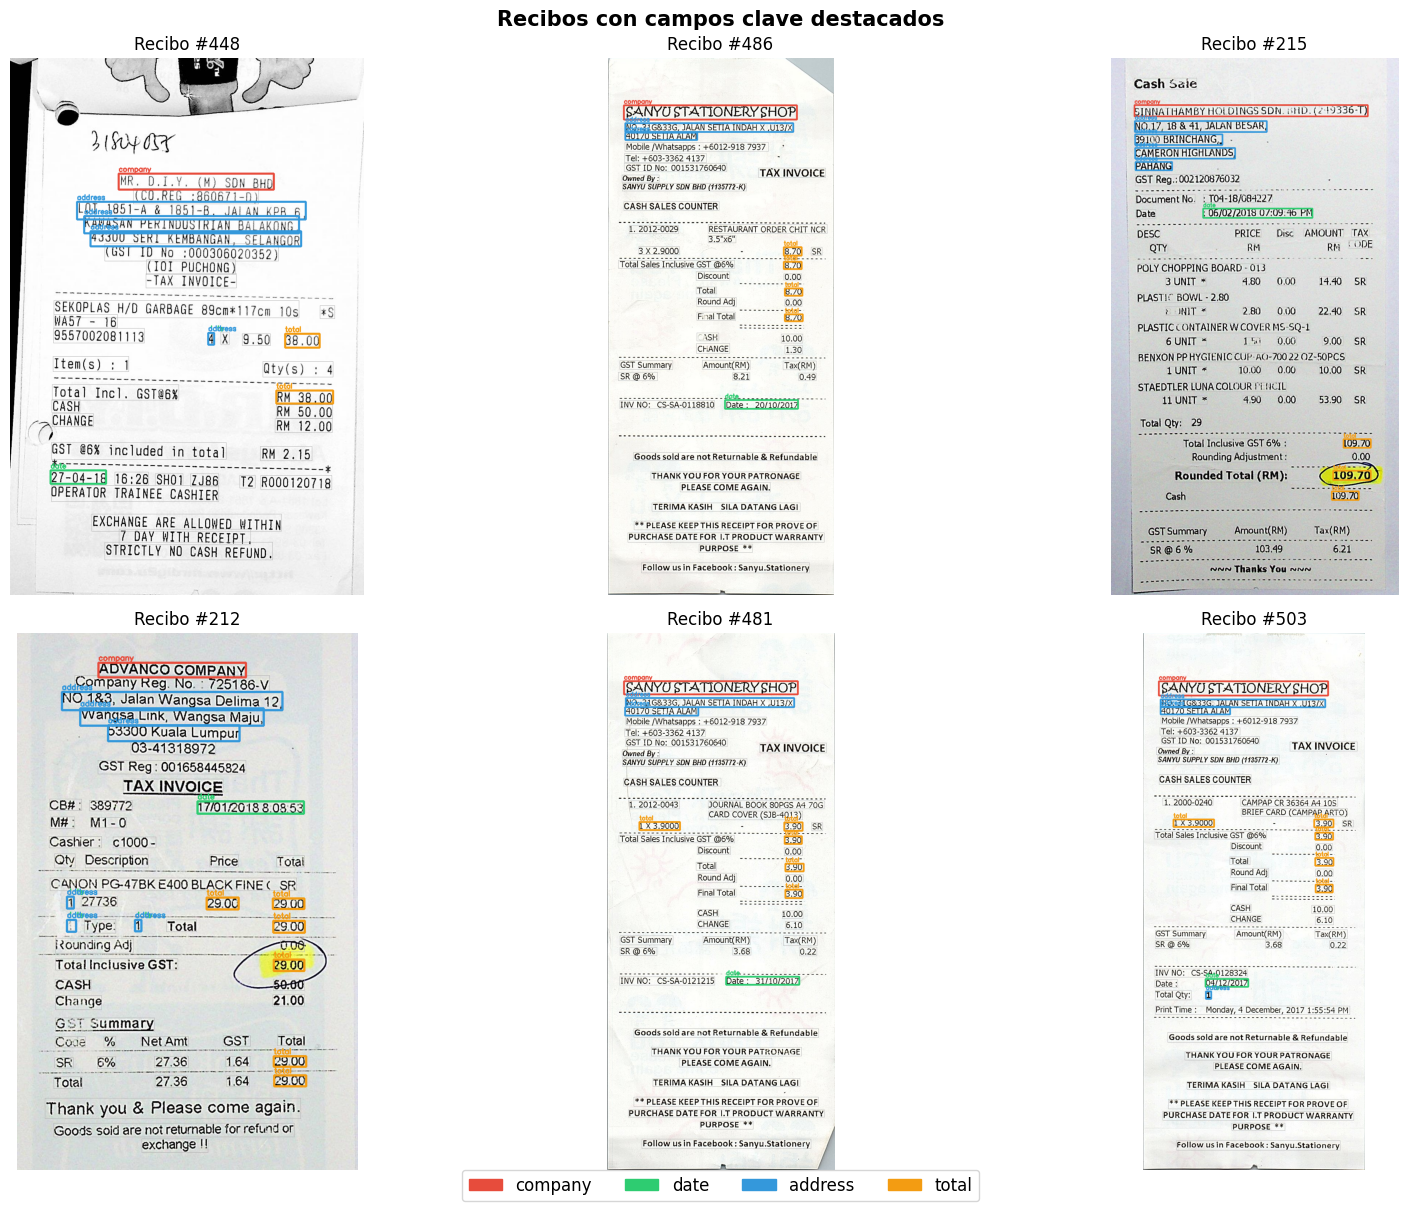

In [12]:
def find_key_boxes(boxes_df: pd.DataFrame, keys: dict) -> dict:
    """
    Busca en boxes_df las filas cuyo texto coincide (parcialmente) con el
    valor de cada campo clave. Retorna {field: list_of_row_indices}.
    """
    matched = {f: [] for f in keys}
    for field, value in keys.items():
        if not value:
            continue
        # Búsqueda fuzzy: normalizar a minúsculas, buscar substring
        value_norm = value.lower().strip()
        for i, row in boxes_df.iterrows():
            if str(row["text"]).lower().strip() in value_norm or \
               value_norm in str(row["text"]).lower().strip():
                matched[field].append(i)
    return matched


def draw_annotated(img, boxes_df, keys, title=""):
    """Dibuja todas las bboxes en gris y los campos clave en color."""
    color_map = {"company":"#E74C3C","date":"#2ECC71","address":"#3498DB","total":"#F39C12"}
    canvas = img.copy()
    matched = find_key_boxes(boxes_df, keys)

    # Pintar bboxes de texto genérico
    for _, row in boxes_df.iterrows():
        pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                        [row.x3,row.y3],[row.x4,row.y4]], np.int32)
        cv2.polylines(canvas, [pts.reshape(-1,1,2)], True, (180,180,180), 1)

    # Pintar campos clave
    for field, idxs in matched.items():
        hex_c = color_map[field].lstrip("#")
        r,g,b = tuple(int(hex_c[i:i+2],16) for i in (0,2,4))
        for i in idxs:
            row = boxes_df.loc[i]
            pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                            [row.x3,row.y3],[row.x4,row.y4]], np.int32)
            cv2.polylines(canvas,[pts.reshape(-1,1,2)],True,(r,g,b),3)
            cv2.putText(canvas, field, (int(row.x1), int(row.y1)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (r,g,b), 2)
    return canvas


# ─── Mostrar 6 muestras aleatorias ───────────────────────────────────────────
np.random.seed(SEED)
sample_ids = np.random.choice(all_indices, 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for ax, idx in zip(axes.flat, sample_ids):
    img, boxes_df, keys = load_sample(idx)
    canvas = draw_annotated(img, boxes_df, keys, title=idx)
    ax.imshow(canvas)
    ax.set_title(f"Recibo #{idx}", fontsize=12)
    ax.axis("off")

# Leyenda
from matplotlib.patches import Patch
legend_handles = [Patch(color=c, label=l) for l, c in
                  [("company","#E74C3C"),("date","#2ECC71"),
                   ("address","#3498DB"),("total","#F39C12")]]
fig.legend(handles=legend_handles, loc="lower center", ncol=4, fontsize=12,
           bbox_to_anchor=(0.5, -0.02))
plt.suptitle("Recibos con campos clave destacados", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

## 4. Preprocesar Imágenes y Generar Máscaras de Segmentación

Cada imagen se redimensiona a `512×512`. Para cada bbox que coincide con un campo clave se dibuja en la máscara el polígono con el ID de clase correspondiente.

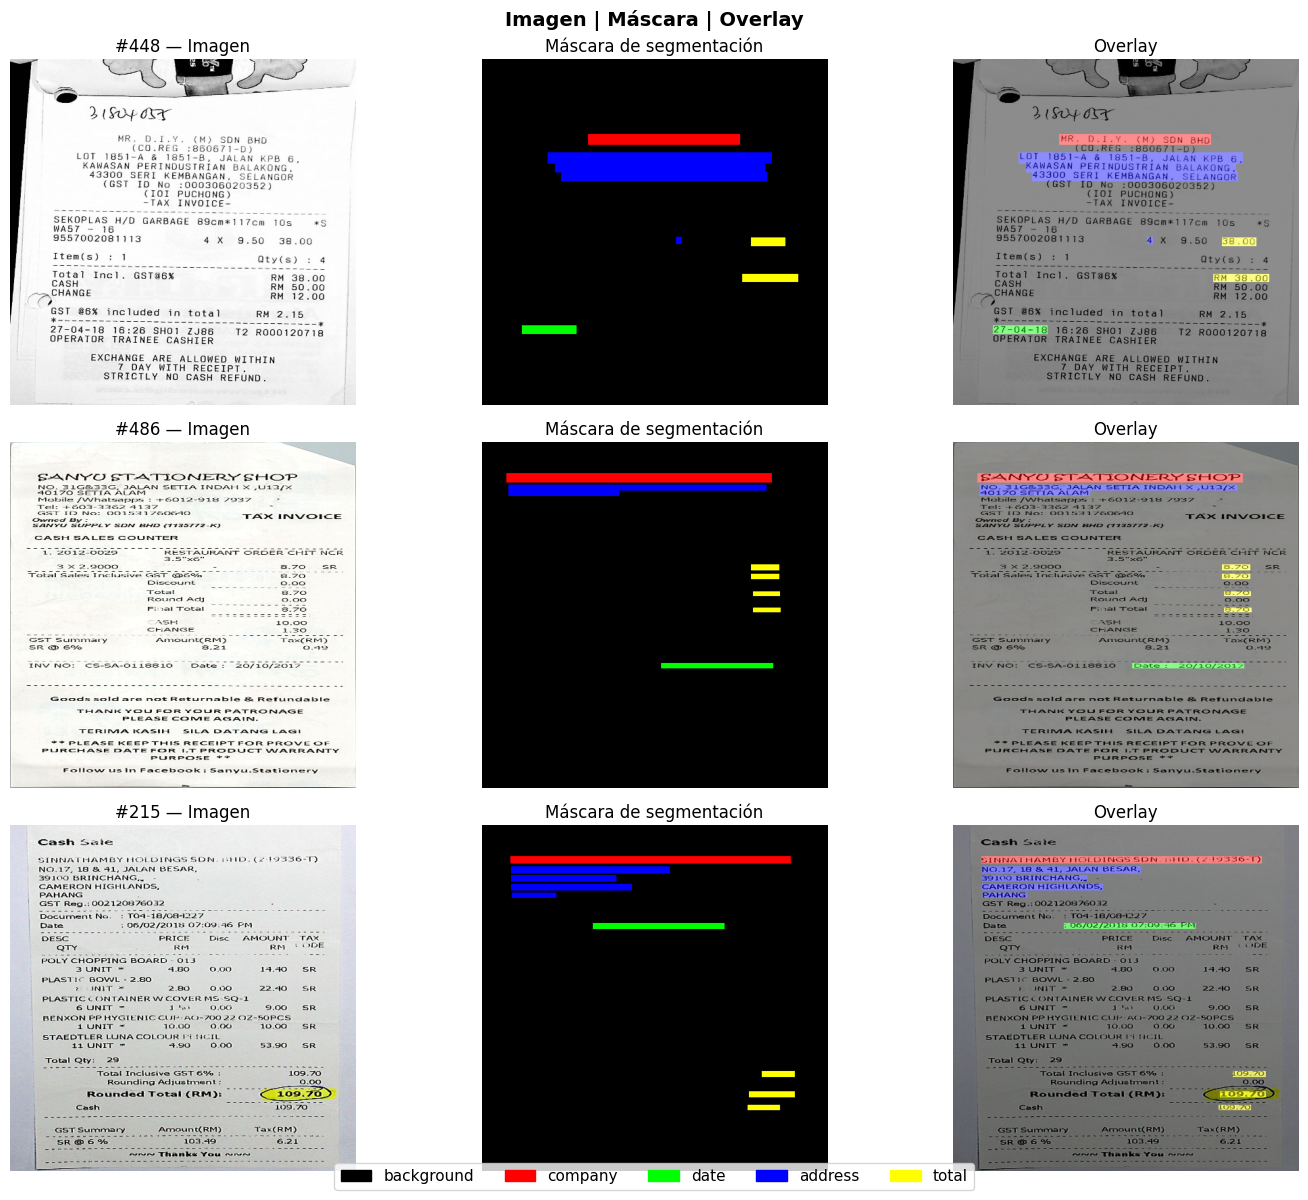

In [13]:
def build_segmentation_mask(img_orig, boxes_df, keys):
    """
    Genera una máscara de segmentación semántica del tamaño original de la imagen.
    Cada píxel inside un bbox de campo clave recibe el ID de clase correspondiente.
    """
    h, w = img_orig.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)  # 0 = background

    matched = find_key_boxes(boxes_df, keys)
    for field, idxs in matched.items():
        class_id = FIELD_CLASSES[field]
        for i in idxs:
            row = boxes_df.loc[i]
            pts = np.array([[row.x1,row.y1],[row.x2,row.y2],
                            [row.x3,row.y3],[row.x4,row.y4]], np.int32)
            cv2.fillPoly(mask, [pts], class_id)
    return mask


def preprocess_sample(idx):
    """Carga, redimensiona y devuelve (img_norm, mask_resized)."""
    img, boxes_df, keys = load_sample(idx)
    mask = build_segmentation_mask(img, boxes_df, keys)

    img_resized  = cv2.resize(img,  (IMG_W, IMG_H), interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (IMG_W, IMG_H), interpolation=cv2.INTER_NEAREST)

    img_norm = img_resized.astype(np.float32) / 255.0
    return img_norm, mask_resized


# ─── Verificación visual de las máscaras ─────────────────────────────────────
cmap = ListedColormap(["black","red","lime","blue","yellow"])

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, idx in enumerate(sample_ids[:3]):
    img_n, mask = preprocess_sample(idx)
    axes[i][0].imshow(img_n);                axes[i][0].set_title(f"#{idx} — Imagen")
    axes[i][1].imshow(mask, cmap=cmap, vmin=0, vmax=4)
    axes[i][1].set_title("Máscara de segmentación")
    axes[i][2].imshow(img_n)
    axes[i][2].imshow(mask, cmap=cmap, vmin=0, vmax=4, alpha=0.45)
    axes[i][2].set_title("Overlay")
    for ax in axes[i]: ax.axis("off")

from matplotlib.patches import Patch
handles = [Patch(color=c, label=n) for c, n in
           zip(["black","red","lime","blue","yellow"], CLASS_NAMES)]
fig.legend(handles=handles, loc="lower center", ncol=5, fontsize=11,
           bbox_to_anchor=(0.5, -0.01))
plt.suptitle("Imagen | Máscara | Overlay", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [14]:
# ─── Dividir dataset en train / val / test (70 / 15 / 15) ───────────────────
train_ids, temp_ids = train_test_split(all_indices, test_size=0.30, random_state=SEED)
val_ids,   test_ids = train_test_split(temp_ids,    test_size=0.50, random_state=SEED)

print(f"Train : {len(train_ids)} muestras")
print(f"Val   : {len(val_ids)}   muestras")
print(f"Test  : {len(test_ids)}  muestras")

Train : 438 muestras
Val   : 94   muestras
Test  : 94  muestras


In [15]:
# ─── tf.data pipeline ────────────────────────────────────────────────────────
def load_tf_sample(idx_tensor):
    idx = idx_tensor.numpy().decode("utf-8")
    img, mask = preprocess_sample(idx)
    return img.astype(np.float32), mask.astype(np.int32)

def tf_load(idx):
    img, mask = tf.py_function(load_tf_sample, [idx], [tf.float32, tf.int32])
    img.set_shape([IMG_H, IMG_W, 3])
    mask.set_shape([IMG_H, IMG_W])
    return img, mask

def make_dataset(ids, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(ids)
    if shuffle:
        ds = ds.shuffle(len(ids), seed=SEED)
    ds = ds.map(tf_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

ds_train = make_dataset(train_ids, shuffle=True)
ds_val   = make_dataset(val_ids,   shuffle=False)
ds_test  = make_dataset(test_ids,  shuffle=False)

print("Datasets creados:")
print(f"  ds_train → {ds_train}")
print(f"  ds_val   → {ds_val}")
print(f"  ds_test  → {ds_test}")

Datasets creados:
  ds_train → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512), dtype=tf.int32, name=None))>
  ds_val   → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512), dtype=tf.int32, name=None))>
  ds_test  → <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512), dtype=tf.int32, name=None))>


## 5. Arquitectura del Modelo — U-Net

Se utiliza **U-Net** con un encoder basado en **MobileNetV2** preentrenado en ImageNet. El decoder reconstruye la resolución mediante bloques de upsampling + convolución, concatenando los skip connections del encoder.

In [16]:
def upsample_block(x, skip, filters, name):
    x = layers.UpSampling2D(2, name=f"{name}_up")(x)
    x = layers.Concatenate(name=f"{name}_concat")([x, skip])
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name}_conv1")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", name=f"{name}_conv2")(x)
    return x


def build_unet(input_shape=(IMG_H, IMG_W, 3), num_classes=NUM_CLASSES):
    """
    U-Net con encoder MobileNetV2 (pretrained ImageNet) y decoder personalizado.
    """
    inp = layers.Input(shape=input_shape, name="input_image")

    # ── Encoder: MobileNetV2 ─────────────────────────────────────────────────
    base = keras.applications.MobileNetV2(
        input_tensor=inp, include_top=False, weights="imagenet"
    )
    base.trainable = False  # Congelar encoder inicialmente

    # Skip connections en resoluciones intermedias
    s1 = base.get_layer("block_1_expand_relu").output   # 256×256
    s2 = base.get_layer("block_3_expand_relu").output   # 128×128
    s3 = base.get_layer("block_6_expand_relu").output   # 64×64
    s4 = base.get_layer("block_13_expand_relu").output  # 32×32
    bridge = base.get_layer("block_16_project").output  # 16×16

    # ── Decoder ───────────────────────────────────────────────────────────────
    d1 = upsample_block(bridge, s4, 512, "dec1")   # → 32×32
    d2 = upsample_block(d1,     s3, 256, "dec2")   # → 64×64
    d3 = upsample_block(d2,     s2, 128, "dec3")   # → 128×128
    d4 = upsample_block(d3,     s1,  64, "dec4")   # → 256×256

    # Última upsample para llegar a 512×512
    x  = layers.UpSampling2D(2, name="final_up")(d4)
    x  = layers.Conv2D(32, 3, padding="same", activation="relu", name="final_conv")(x)

    # Capa de salida — una probabilidad por clase por píxel
    out = layers.Conv2D(num_classes, 1, activation="softmax", name="output_mask")(x)

    model = Model(inputs=inp, outputs=out, name="UNet_MobileNetV2")
    return model


unet = build_unet()
unet.summary(line_length=90)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "UNet_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)             ┃ Output Shape         ┃      Param # ┃ Connected to          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer) │ (None, 512, 512, 3)  │            0 │ -                     │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ Conv1 (Conv2D)           │ (None, 256, 256, 32) │          864 │ input_image[0][0]     │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ bn_Conv1                 │ (None, 256, 256, 32) │          128 │ Conv1[0][0]           │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ Conv1_relu (ReLU)        │ (None, 256, 256, 32) │            0 │ bn_Conv1[0][0]        │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise  │ (None, 256, 256, 32) │          288 │ Conv1_relu[0][0]      │
│ (DepthwiseConv2D)        │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise… │ (None, 256, 256, 32) │          128 │ expanded_conv_depthw… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_depthwise… │ (None, 256, 256, 32) │            0 │ expanded_conv_depthw… │
│ (ReLU)                   │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project    │ (None, 256, 256, 16) │          512 │ expanded_conv_depthw… │
│ (Conv2D)                 │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ expanded_conv_project_BN │ (None, 256, 256, 16) │           64 │ expanded_conv_projec… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand (Conv2D)  │ (None, 256, 256, 96) │        1,536 │ expanded_conv_projec… │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand_BN        │ (None, 256, 256, 96) │          384 │ block_1_expand[0][0]  │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_expand_relu      │ (None, 256, 256, 96) │            0 │ block_1_expand_BN[0]… │
│ (ReLU)                   │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_pad              │ (None, 257, 257, 96) │            0 │ block_1_expand_relu[… │
│ (ZeroPadding2D)          │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_depthwise        │ (None, 128, 128, 96) │          864 │ block_1_pad[0][0]     │
│ (DepthwiseConv2D)        │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼───────────────────────┤
│ block_1_depthwise_BN     │ (None, 128, 128, 96) │          384 │ block_1_depthwise[0]… │
│ (BatchNormalization)     │                      │              │                       │
├──────────────────────────┼──────────────────────┼──────────────┼─────────────────────

 Total params: 11,336,581 (43.25 MB)

 Trainable params: 9,494,597 (36.22 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

## 6. Entrenamiento del Modelo

In [18]:
# ─── Función de pérdida: Sparse Categorical Crossentropy + pesos por clase ───
# Las clases 1-4 son minoritarias vs background → se les da mayor peso
class_weights = np.array([0.1, 2.0, 2.0, 2.0, 2.0], dtype=np.float32)

def weighted_sparse_cce(y_true, y_pred):
    scce   = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    # Convertir etiquetas en pesos
    w_map  = tf.gather(class_weights, tf.cast(y_true, tf.int32))
    loss   = scce * w_map
    return tf.reduce_mean(loss)


# ─── Métrica: Mean IoU Adaptada ───────────────────────────────────────────────
class SparseMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name=None, dtype=None):
        super(SparseMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred viene como probabilidades (B, H, W, C) -> convertir a clases (B, H, W)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

mean_iou = SparseMeanIoU(num_classes=NUM_CLASSES, name="mean_iou")


# ─── Compilar ─────────────────────────────────────────────────────────────────
unet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=weighted_sparse_cce,
    metrics=["accuracy", mean_iou]
)

# ─── Callbacks ────────────────────────────────────────────────────────────────
CKPT_PATH = os.path.join(BASE_DIR, "best_unet.keras")

callbacks = [
    ModelCheckpoint(CKPT_PATH, monitor="val_mean_iou", mode="max",
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_mean_iou", mode="max", patience=7,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3,
                      min_lr=1e-6, verbose=1)
]

print("Modelo compilado. Iniciando entrenamiento...")
history = unet.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callbacks
)

Modelo compilado. Iniciando entrenamiento...
Epoch 1/30
53/55 ━━━━━━━━━━━━━━━━━━━━ 1:32 46s/step - accuracy: 0.7404 - loss: 0.3632 - mean_iou: 0.1659

KeyboardInterrupt: 

In [ ]:
# ─── Fine-tuning: descongelar encoder y entrenar con LR bajo ─────────────────
print("=== Fine-tuning: descongelando encoder ===")
unet.get_layer("mobilenetv2_1.00_512").trainable = True

unet.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=weighted_sparse_cce,
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name="mean_iou")]
)

history_ft = unet.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=callbacks
)

In [ ]:
# ─── Curvas de entrenamiento ─────────────────────────────────────────────────
def plot_history(hist, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(17, 4))
    for ax, metric, label in zip(axes,
                                  ["loss",      "accuracy",   "mean_iou"],
                                  ["Loss",      "Accuracy",   "Mean IoU"]):
        ax.plot(hist.history[metric],     label="Train")
        ax.plot(hist.history[f"val_{metric}"], label="Val", linestyle="--")
        ax.set_title(f"{title} — {label}")
        ax.set_xlabel("Época"); ax.legend()
    plt.tight_layout(); plt.show()

plot_history(history,    "Fase 1 (encoder congelado)")
plot_history(history_ft, "Fase 2 (fine-tuning)")

## 7. Evaluación del Modelo

Se calculan **Mean IoU por clase**, **Pixel Accuracy** y **Precision / Recall / F1** sobre el conjunto de test.

In [ ]:
# ─── Evaluar en test set ─────────────────────────────────────────────────────
print("Evaluando en test set...")
results = unet.evaluate(ds_test, verbose=1)
print(f"\n  Loss         : {results[0]:.4f}")
print(f"  Pixel Acc    : {results[1]:.4f}")
print(f"  Mean IoU     : {results[2]:.4f}")

In [ ]:
# ─── IoU por clase + reporte de clasificación ────────────────────────────────
y_true_all, y_pred_all = [], []

for imgs, masks in ds_test:
    preds  = unet.predict(imgs, verbose=0)
    pred_classes = np.argmax(preds, axis=-1)      # (B, H, W)
    y_true_all.append(masks.numpy().flatten())
    y_pred_all.append(pred_classes.flatten())

y_true_flat = np.concatenate(y_true_all)
y_pred_flat = np.concatenate(y_pred_all)

# IoU por clase
iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)
iou_metric.update_state(y_true_flat, y_pred_flat)
cm = iou_metric.total_cm.numpy()

iou_per_class = {}
for i in range(NUM_CLASSES):
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    denom = tp + fp + fn
    iou_per_class[CLASS_NAMES[i]] = tp / denom if denom > 0 else 0.0

print("IoU por clase:")
for cls, iou in iou_per_class.items():
    print(f"  {cls:>12s} : {iou:.4f}")
print(f"\n  Mean IoU  : {np.mean(list(iou_per_class.values())):.4f}")

print("\nReporte de clasificación (nivel píxel):")
print(classification_report(y_true_flat, y_pred_flat,
                             target_names=CLASS_NAMES, zero_division=0))

In [ ]:
# ─── Matriz de confusión (normalizada) ────────────────────────────────────────
cm_norm = cm.astype(float)
row_sums = cm_norm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
cm_norm /= row_sums

fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
ax.set_xticks(range(NUM_CLASSES)); ax.set_xticklabels(CLASS_NAMES, rotation=30, ha="right")
ax.set_yticks(range(NUM_CLASSES)); ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_title("Matriz de confusión normalizada (nivel píxel)")
plt.colorbar(im, ax=ax)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center",
                color="white" if cm_norm[i,j] > 0.5 else "black", fontsize=9)
plt.tight_layout()
plt.show()

## 8. Inferencia en Imágenes Nuevas

Se carga el mejor checkpoint, se realizan predicciones y se visualizan los campos detectados con sus etiquetas y el score de confianza promedio por región.

In [ ]:
# ─── Cargar el mejor modelo guardado ─────────────────────────────────────────
best_model = keras.models.load_model(
    CKPT_PATH,
    custom_objects={"weighted_sparse_cce": weighted_sparse_cce}
)
print(f"Modelo cargado desde: {CKPT_PATH}")

In [ ]:
def predict_and_visualize(idx, model, threshold=0.5):
    """
    Predice la máscara de segmentación para un idx y visualiza:
    - Imagen original
    - Máscara predicha
    - Overlay con contornos de campos detectados y confianza promedio
    """
    img, boxes_df, keys = load_sample(idx)
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    img_norm    = img_resized.astype(np.float32) / 255.0

    # Predicción
    inp   = np.expand_dims(img_norm, 0)   # (1, H, W, 3)
    probs = model.predict(inp, verbose=0)[0]   # (H, W, C)
    pred_mask = np.argmax(probs, axis=-1)       # (H, W)

    # Overlay con contornos por clase
    overlay = img_resized.copy()
    color_bgr = {1:(255,60,60), 2:(60,220,60), 3:(60,60,255), 4:(220,200,0)}

    for cls_id, color in color_bgr.items():
        cls_mask = (pred_mask == cls_id).astype(np.uint8) * 255
        if cls_mask.max() == 0:
            continue
        contours, _ = cv2.findContours(cls_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 3)
        # Confianza promedio en la región
        conf = probs[:,:,cls_id][pred_mask == cls_id].mean()
        for cnt in contours:
            x, y, w_c, h_c = cv2.boundingRect(cnt)
            label_text = f"{CLASS_NAMES[cls_id]} {conf:.2f}"
            cv2.putText(overlay, label_text, (x, max(y-6, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)

    # Figura
    fig, axes = plt.subplots(1, 3, figsize=(17, 6))
    axes[0].imshow(img_resized);         axes[0].set_title(f"Original #{idx}")
    axes[1].imshow(pred_mask, cmap=cmap, vmin=0, vmax=4)
    axes[1].set_title("Máscara predicha")
    axes[2].imshow(overlay);             axes[2].set_title("Campos detectados")
    for ax in axes: ax.axis("off")

    from matplotlib.patches import Patch
    handles = [Patch(color=c, label=n) for c, n in
               zip(["red","lime","blue","yellow"], CLASS_NAMES[1:])]
    fig.legend(handles=handles, loc="lower center", ncol=4, fontsize=11,
               bbox_to_anchor=(0.5, -0.01))
    plt.tight_layout()
    plt.show()

    return pred_mask, probs


# ─── Correr inferencia en 4 muestras del test set ─────────────────────────────
np.random.seed(99)
infer_ids = np.random.choice(test_ids, 4, replace=False)

for idx in infer_ids:
    predict_and_visualize(idx, best_model)

In [ ]:
# ─── Inferencia en una imagen externa (fuera del dataset) ────────────────────
# Reemplaza la ruta por una imagen de recibo propia si deseas probar
def predict_external(image_path, model):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_W, IMG_H))
    img_norm    = img_resized.astype(np.float32) / 255.0
    inp  = np.expand_dims(img_norm, 0)
    probs     = model.predict(inp, verbose=0)[0]
    pred_mask = np.argmax(probs, axis=-1)

    overlay = img_resized.copy()
    color_bgr = {1:(255,60,60), 2:(60,220,60), 3:(60,60,255), 4:(220,200,0)}
    for cls_id, color in color_bgr.items():
        cls_mask = (pred_mask == cls_id).astype(np.uint8) * 255
        if cls_mask.max() == 0:
            continue
        contours, _ = cv2.findContours(cls_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 3)
        conf = probs[:,:,cls_id][pred_mask == cls_id].mean()
        for cnt in contours:
            x, y, w_c, h_c = cv2.boundingRect(cnt)
            cv2.putText(overlay, f"{CLASS_NAMES[cls_id]} {conf:.2f}", (x, max(y-6,10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_resized); axes[0].set_title("Imagen de entrada")
    axes[1].imshow(overlay);     axes[1].set_title("Campos detectados")
    for ax in axes: ax.axis("off")
    plt.tight_layout(); plt.show()

    # Extraer texto del campo total como ejemplo
    for cls_id in range(1, NUM_CLASSES):
        region = pred_mask == cls_id
        coverage = region.sum() / region.size
        print(f"  {CLASS_NAMES[cls_id]:>12s}: cobertura={coverage*100:.2f}%  "
              f"conf_media={probs[:,:,cls_id][region].mean() if region.any() else 0:.3f}")


# Ejemplo de uso — descomenta y ajusta la ruta:
# predict_external(r"C:\ruta\a\recibo_nuevo.jpg", best_model)
print("Celda lista. Descomenta predict_external(...) con tu propia imagen.")

# Task
Clone the GitHub repository `https://github.com/zzzDavid/ICDAR-2019-SROIE.git` to the current directory to retrieve the dataset files needed for the `data/` directory.

## Clone GitHub Repository

### Subtask:
Clone the GitHub repository containing the SROIE dataset.


**Reasoning**:
Clone the specified GitHub repository to retrieve the dataset and list the contents to verify the file structure as per the subtask instructions.



In [4]:
!git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
!ls -R ICDAR-2019-SROIE

Cloning into 'ICDAR-2019-SROIE'...
remote: Enumerating objects: 2386, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2386 (delta 18), reused 18 (delta 18), pack-reused 2366 (from 1)
Receiving objects: 100% (2386/2386), 278.64 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (1980/1980), done.
ICDAR-2019-SROIE:
data		 LICENSE  README.md  task1	   task2  task3_revamp
environment.yml  Media	  scripts    task1_revamp  task3

ICDAR-2019-SROIE/data:
box  img  key

ICDAR-2019-SROIE/data/box:
000.csv  070.csv  140.csv  210.csv  280.csv  350.csv  420.csv  490.csv	560.csv
001.csv  071.csv  141.csv  211.csv  281.csv  351.csv  421.csv  491.csv	561.csv
002.csv  072.csv  142.csv  212.csv  282.csv  352.csv  422.csv  492.csv	562.csv
003.csv  073.csv  143.csv  213.csv  283.csv  353.csv  423.csv  493.csv	563.csv
004.csv  074.csv  144.csv  214.csv  284.csv  354.csv  424.csv  494.csv	564.csv
005.csv  075

**Reasoning**:
The dataset was successfully cloned into 'ICDAR-2019-SROIE/data', but the notebook expects the data to be in a root-level 'data' directory (as indicated by the variable 'DATA_DIR'). I will now move the 'data' directory to the current working directory to match the expected structure.



In [6]:
import shutil
import os

src_path = 'ICDAR-2019-SROIE/data'
dst_path = 'data'

# Check if the source data exists
if os.path.exists(src_path):
    # Remove existing 'data' directory if it exists to avoid conflicts
    if os.path.exists(dst_path):
        shutil.rmtree(dst_path)

    # Move the data directory to the current working directory
    shutil.move(src_path, '.')
    print(f"Successfully moved '{src_path}' to './{dst_path}'.")

    # Verify the contents of the new data directory
    if os.path.exists(dst_path):
        print(f"Contents of '{dst_path}': {os.listdir(dst_path)}")
else:
    print(f"Source path '{src_path}' not found. Please verify the clone operation.")

Successfully moved 'ICDAR-2019-SROIE/data' to './data'.
Contents of 'data': ['key', 'box', 'img']


## Verify Data Loading

### Subtask:
Reload the dataset indices and verify that images and annotations are accessible.


**Reasoning**:
Re-define the data loading function and scan the directory to populate the indices list, then verify by loading the first sample.



In [7]:
def load_sample(idx: str):
    """
    Carga imagen, bounding boxes y etiquetas clave para un índice dado.
    El CSV tiene columnas: x1,y1,x2,y2,x3,y3,x4,y4,text  (sin encabezado)
    El JSON contiene: company, date, address, total
    """
    img_path = os.path.join(IMG_DIR, f"{idx}.jpg")
    box_path = os.path.join(BOX_DIR, f"{idx}.csv")
    key_path = os.path.join(KEY_DIR, f"{idx}.json")

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    boxes_df = pd.read_csv(box_path, header=None,
                           names=["x1","y1","x2","y2","x3","y3","x4","y4","text"])

    with open(key_path) as f:
        keys = json.load(f)

    return img, boxes_df, keys

# ─── Listar todos los índices disponibles ────────────────────────────────────
all_indices = sorted([
    os.path.splitext(os.path.basename(p))[0]
    for p in glob.glob(os.path.join(IMG_DIR, "*.jpg"))
])

print(f"Total de muestras: {len(all_indices)}")
if len(all_indices) > 0:
    print(f"Primeros índices  : {all_indices[:5]}")
    print(f"Últimos índices   : {all_indices[-5:]}")

    # ─── Estadísticas básicas ─────────────────────────────────────────────────────
    img_sample, boxes_sample, keys_sample = load_sample(all_indices[0])
    print(f"\nEjemplo índice {all_indices[0]}:")
    print(f"  Imagen shape : {img_sample.shape}")
    print(f"  Num bboxes   : {len(boxes_sample)}")
    print(f"  Campos clave : {list(keys_sample.keys())}")
    print(f"  Valores      : {keys_sample}")
else:
    print("No images found in IMG_DIR. Please check the data path.")

Total de muestras: 626
Primeros índices  : ['000', '001', '002', '003', '004']
Últimos índices   : ['621', '622', '623', '624', '625']


ParserError: Error tokenizing data. C error: Expected 9 fields in line 4, saw 12


**Reasoning**:
The `pd.read_csv` function caused a `ParserError` because some rows in the CSV files contain commas within the text field (the last column), which the default parser interprets as extra delimiters. I will redefine `load_sample` to parse the files manually line-by-line, splitting the first 8 comma-separated values as coordinates and joining the remaining parts as the text content. This robustly handles commas inside the text labels.



In [8]:
def load_sample(idx: str):
    """
    Carga imagen, bounding boxes y etiquetas clave para un índice dado.
    El CSV tiene columnas: x1,y1,x2,y2,x3,y3,x4,y4,text  (sin encabezado)
    El JSON contiene: company, date, address, total
    """
    img_path = os.path.join(IMG_DIR, f"{idx}.jpg")
    box_path = os.path.join(BOX_DIR, f"{idx}.csv")
    key_path = os.path.join(KEY_DIR, f"{idx}.json")

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Manual parsing to handle commas in the text field
    data = []
    with open(box_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.strip().split(",")
            # We expect at least 8 coordinates + 1 text (or empty text)
            if len(parts) >= 8:
                try:
                    # Extract coordinates (first 8 values)
                    coords = [int(p) for p in parts[:8]]
                    # The rest is the text (re-joined in case of commas)
                    text = ",".join(parts[8:])
                    data.append(coords + [text])
                except ValueError:
                    # Skip malformed lines (e.g. headers or non-integer coords)
                    continue

    boxes_df = pd.DataFrame(data, columns=["x1","y1","x2","y2","x3","y3","x4","y4","text"])

    with open(key_path) as f:
        keys = json.load(f)

    return img, boxes_df, keys

# ─── Listar todos los índices disponibles ────────────────────────────────────
all_indices = sorted([
    os.path.splitext(os.path.basename(p))[0]
    for p in glob.glob(os.path.join(IMG_DIR, "*.jpg"))
])

print(f"Total de muestras: {len(all_indices)}")
if len(all_indices) > 0:
    print(f"Primeros índices  : {all_indices[:5]}")
    print(f"Últimos índices   : {all_indices[-5:]}")

    # ─── Estadísticas básicas ─────────────────────────────────────────────────────
    try:
        img_sample, boxes_sample, keys_sample = load_sample(all_indices[0])
        print(f"\nEjemplo índice {all_indices[0]}:")
        print(f"  Imagen shape : {img_sample.shape}")
        print(f"  Num bboxes   : {len(boxes_sample)}")
        print(f"  Campos clave : {list(keys_sample.keys())}")
        print(f"  Valores      : {keys_sample}")
    except Exception as e:
        print(f"Error verifying sample {all_indices[0]}: {e}")
else:
    print("No images found in IMG_DIR. Please check the data path.")

Total de muestras: 626
Primeros índices  : ['000', '001', '002', '003', '004']
Últimos índices   : ['621', '622', '623', '624', '625']

Ejemplo índice 000:
  Imagen shape : (1013, 463, 3)
  Num bboxes   : 44
  Campos clave : ['company', 'date', 'address', 'total']
  Valores      : {'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}


## Final Task

### Subtask:
Visualize the data and prepare the training pipeline to confirm data integrity.


## Summary:

### Data Analysis Key Findings

*   **Dataset Acquisition:** The SROIE dataset was successfully cloned from the external repository and reorganized into a local `data/` directory containing `img` (images), `box` (bounding boxes), and `key` (ground truth entities) subfolders.
*   **Dataset Volume:** A total of **626** samples (image and annotation pairs) were identified and indexed for processing.
*   **Data Format Resolution:** Standard CSV parsing failed due to commas existing within the text fields of the bounding box files. A custom parsing mechanism was implemented to correctly separate the 8 coordinate integers from the text string, resolving the issue.
*   **Sample Verification:** The data loading pipeline was verified using sample index `000`. The system correctly loaded an image of shape `(1013, 463, 3)`, parsed **44** bounding box entries, and retrieved the corresponding JSON keys (`company`, `date`, `address`, `total`).

### Insights or Next Steps

*   **Robust Preprocessing:** Future data loaders for this project must utilize the custom line-parsing logic (splitting the first 8 values as coordinates and joining the rest as text) to prevent crashes caused by punctuation in invoice text.
*   **Visual Confirmation:** With the data loader functioning, the immediate next step is to visualize the bounding boxes overlaid on the images to confirm that the coordinate systems (e.g., origin point) align perfectly before training begins.
